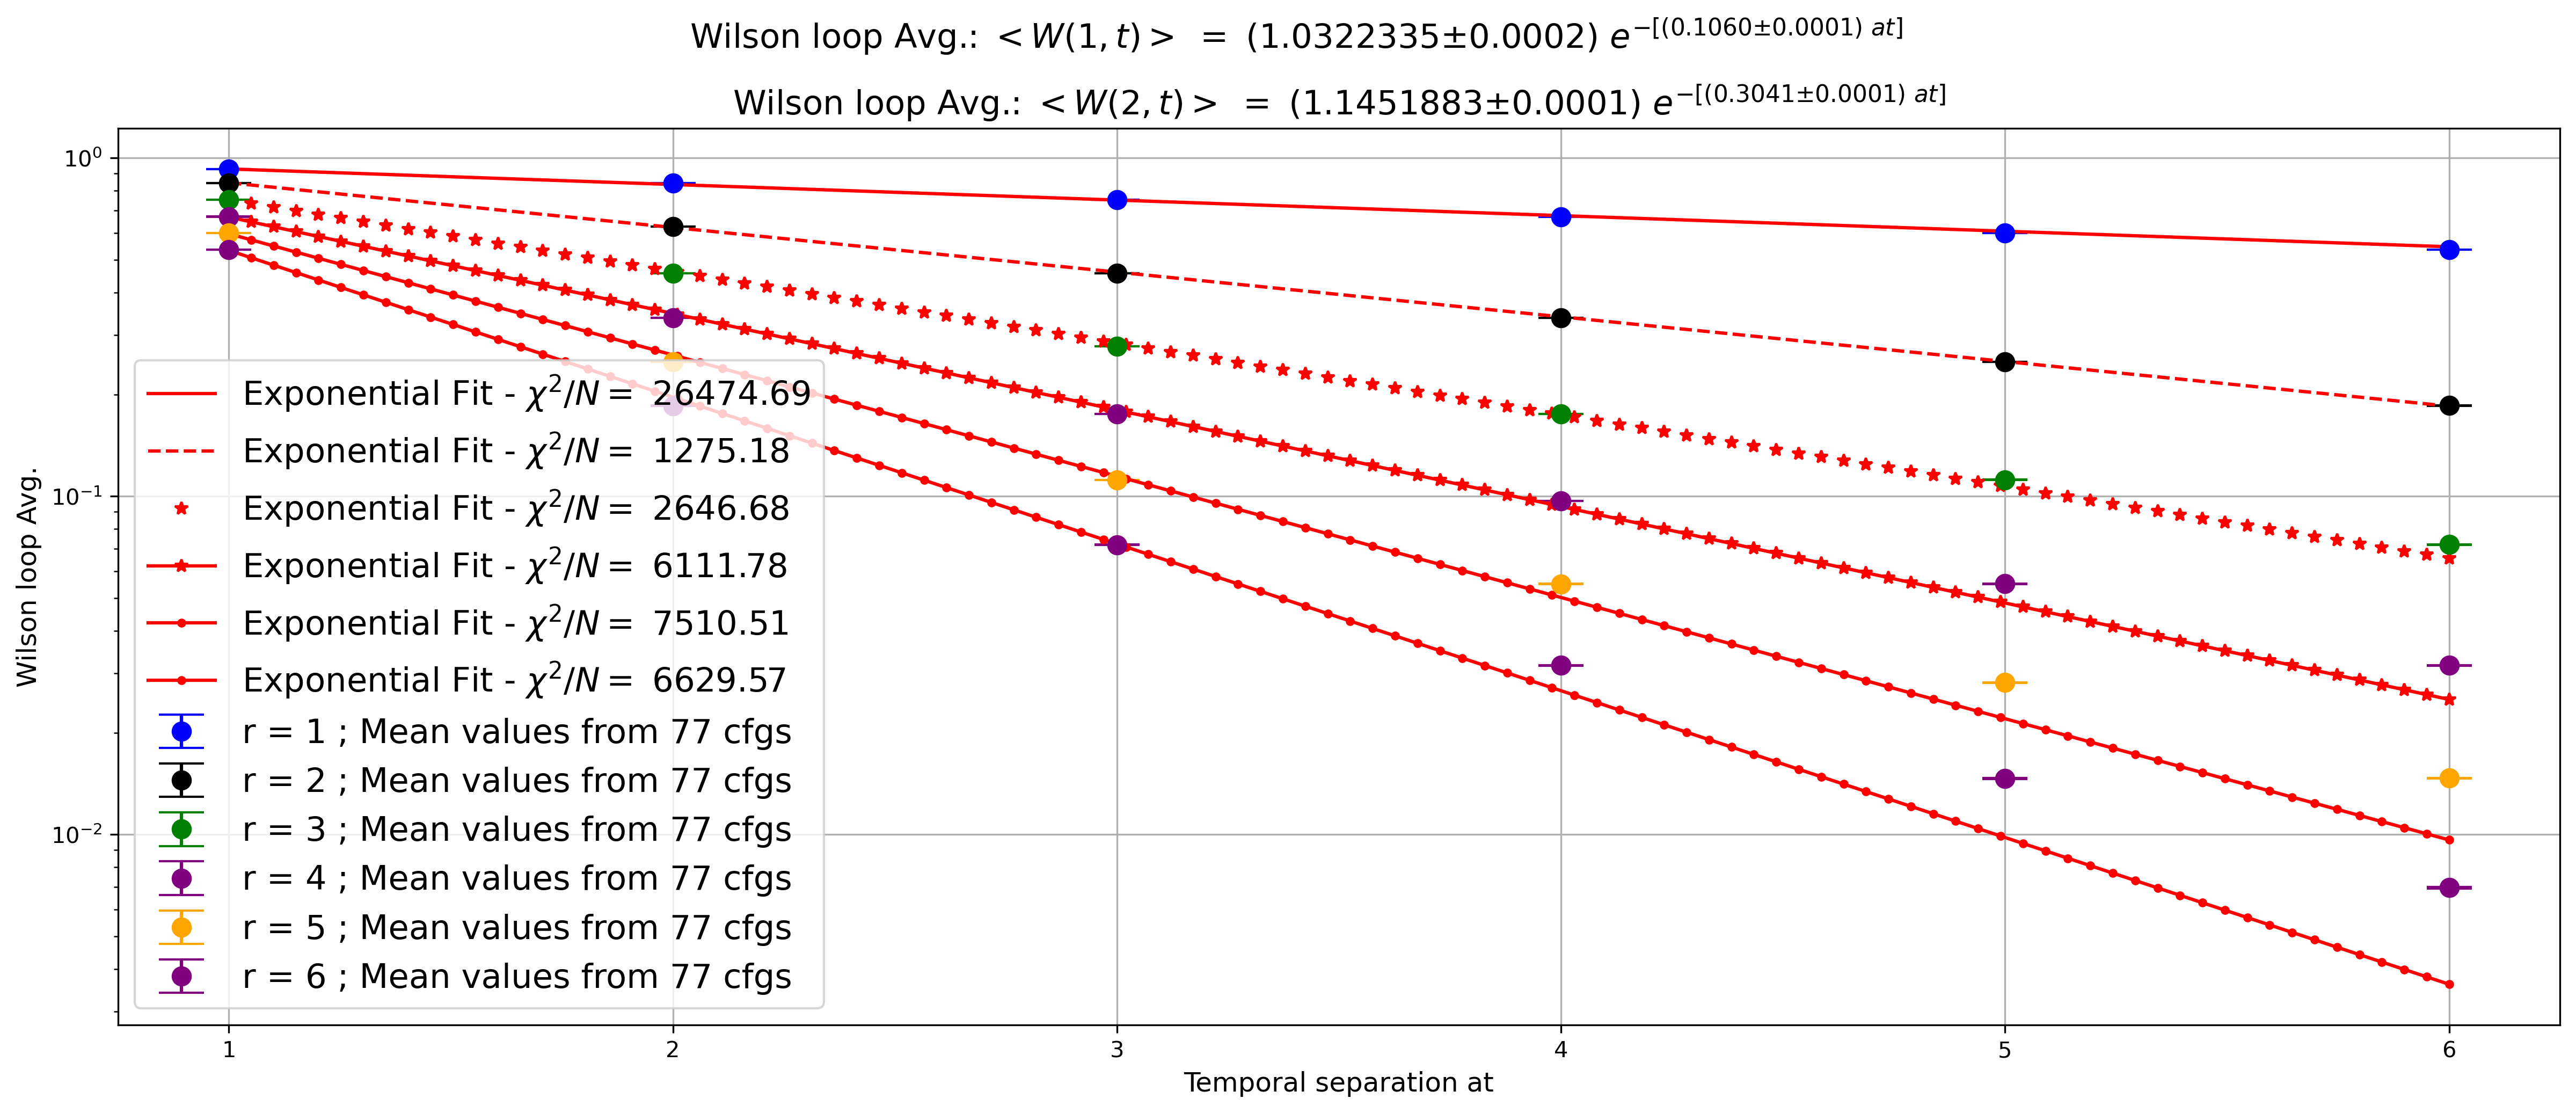

/tmp/ipykernel_1989086/64762512.py:16: RuntimeWarning: overflow encountered in exp
  return V_r + c_1 * np.exp(-c_2 * x)+ c_3 * np.exp(-c_4 * x)


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Exponential decay function 
def exponential_decay(x, A, E):
    return A * np.exp(-E * x)


#lattice size a
a = 0.114

# V(r,t) function 
def V_r_t(x, V_r, c_1, c_2, c_3, c_4):
    return V_r + c_1 * np.exp(-c_2 * x)+ c_3 * np.exp(-c_4 * x)


# V(r) function 
def V_r(x, B, A, sigma_fit):
    return A +(B/x)+(sigma_fit*x)


def wilson_loop(r):
    list_list_all_size_avg_wilsonloop_all_cfgs = []
    sample_size = 0
    for cfgs in range(1776, 2081, 4):
        sample_size = sample_size + 1
        file_path = f"/global/homes/h/hari_8/QLUA_tutorials/wilson_loops_from_configs/wilson_loops_function_cfg_{cfgs}_upto_20x20_creutz_ratio.h5"
        with h5py.File(file_path, "r") as h5_file:
            list_all_size_avg_wilsonloop_per_cfg = []
            for t in range(1,8,1):
                list_avg_wilsonloop_for_each_size = []
                for i_axis in range(0,1,1):
                    path_to_WilsonLoops = f"/Wilson_loops/wilson_{r}_x_{t}/i_{i_axis}_j_3"
                    wilsonloop = h5_file[path_to_WilsonLoops]
                    list_avg_wilsonloop_for_each_size.append(wilsonloop[()])
                list_all_size_avg_wilsonloop_per_cfg.append(np.mean(list_avg_wilsonloop_for_each_size)) 
            list_list_all_size_avg_wilsonloop_all_cfgs.append(list_all_size_avg_wilsonloop_per_cfg)
    return list_list_all_size_avg_wilsonloop_all_cfgs, sample_size

def exp_fit__Jackknife(r):
    list_list_wilsonloop_cfgs, sample_size = wilson_loop(r)
    t_for_plot = list(range(1, 7))
    # original set (for Jackknife)
    mean_wilson_original = []
    error_bar_wilson_original = []
    for size in range(len(range(1,7,1))): #t index start from 0 (not the time t)
        wilson_list_size_original = [size_wilson_list[size] for size_wilson_list in list_list_wilsonloop_cfgs]
        mean_size_original = np.mean(wilson_list_size_original)
        std_error_of_mean_size_original = np.std(wilson_list_size_original)/np.sqrt((sample_size)-1) 
        mean_wilson_original.append(mean_size_original)
        error_bar_wilson_original.append(std_error_of_mean_size_original)
    params_original, cov_original = curve_fit(exponential_decay, t_for_plot, mean_wilson_original, sigma = error_bar_wilson_original, absolute_sigma=True, maxfev=1000)
    A_fit_original, V_fit_original = params_original
    # making N Jackknife sets
    A_sigma_square_Jackknife = 0
    V_sigma_square_Jackknife = 0
    V_Jackknife_list = []
    A_Jackknife_list = []
    for i in range(len(list_list_wilsonloop_cfgs)): #Jackknife
        sliced_list_list = list_list_wilsonloop_cfgs[:(i)] + list_list_wilsonloop_cfgs[(i+1):]
        mean_wilson_Jackknife = []
        error_bar_wilson_Jackknife = []
        for size in range(len(range(1,7,1))): #t index start from 0 (not the time t)
            wilson_list_size = [size_wilson_list_sliced[size] for size_wilson_list_sliced in sliced_list_list]
            mean_size = np.mean(wilson_list_size)
            std_error_of_mean_size = np.std(wilson_list_size)/np.sqrt((sample_size-1)-1)
            mean_wilson_Jackknife.append(mean_size)
            error_bar_wilson_Jackknife.append(std_error_of_mean_size)
        params, cov = curve_fit(exponential_decay, t_for_plot, mean_wilson_Jackknife, sigma = error_bar_wilson_Jackknife, absolute_sigma=True, maxfev=1000)
        A_fit, V_fit = params
        V_Jackknife_list.append(V_fit)
        A_Jackknife_list.append(A_fit)
        A_sigma_square_Jackknife = A_sigma_square_Jackknife + np.square(A_fit-A_fit_original)
        V_sigma_square_Jackknife = V_sigma_square_Jackknife + np.square(V_fit-V_fit_original)
    A_variance = np.sqrt((A_sigma_square_Jackknife*(sample_size-1))/(sample_size))
    V_variance = np.sqrt((V_sigma_square_Jackknife*(sample_size-1))/(sample_size))
    # making jackknife set for just error bars
    error_wilson = []
    for t in range(len(range(1, 7))): #t index start from 0 (not the time t)
        wilson_sigma_square_Jackknife = 0
        for i in range(len(list_list_wilsonloop_cfgs)): #Jackknife
            sliced_list_list = list_list_wilsonloop_cfgs[:(i)] + list_list_wilsonloop_cfgs[(i+1):]
            wilson_t_Jackknife = [t_wilson_list[t] for t_wilson_list in sliced_list_list]
            mean_wilson_t_Jackknife = np.mean(wilson_t_Jackknife)
            wilson_sigma_square_Jackknife = wilson_sigma_square_Jackknife + np.square(mean_wilson_original[t]-mean_wilson_t_Jackknife)
        wilson_variance = np.sqrt((wilson_sigma_square_Jackknife*(sample_size-1))/(sample_size))
        error_wilson.append(wilson_variance)
    ##############################  
    
    return A_fit_original, A_variance, V_fit_original, V_variance, mean_wilson_original, error_bar_wilson_original, t_for_plot, sample_size




def two_wilson_exp_plot():
    plt.subplots(figsize=(16, 7),dpi=300)
    plt_color = ['blue' , 'black', 'green', 'purple', 'orange', 'purple']
    plt_fit_color = ['r-', 'r--', 'r*', 'r*-', 'r.-', 'r.-']
    A_fit_original_list = []
    A_variance_list = []
    V_fit_original_list = []
    V_variance_list = []
    for r in range(1,7):
        A_fit_original, A_variance, V_fit_original, V_variance, mean_wilson_original, error_bar_wilson_original, t_for_plot, sample_size = exp_fit__Jackknife(r)
        A_fit_original_list.append(A_fit_original)
        A_variance_list.append(A_variance)
        V_fit_original_list.append(V_fit_original)
        V_variance_list.append(V_variance)
        ########################## Chi^2 minimization
        chi_squ = 0
        for t in range(1, 7):
            chi_squ = chi_squ + (np.square(mean_wilson_original[t-1]-exponential_decay(t, A_fit_original, V_fit_original)))/(np.square(error_bar_wilson_original[t-1]))
            chi_squ_dof = chi_squ/len(mean_wilson_original)
        ########### plots 
        x_curve = np.linspace(np.min(t_for_plot), np.max(t_for_plot), 100)
        y_curve = exponential_decay(x_curve, A_fit_original, V_fit_original)
        plt.errorbar(t_for_plot, mean_wilson_original, yerr = error_bar_wilson_original, fmt='o', markersize=8, capsize=10, color=plt_color[r-1], label= 'r = {} ; Mean values from {} cfgs'.format(r, sample_size))
        plt.plot(x_curve, y_curve, plt_fit_color[r-1], label='Exponential Fit - $\chi^2/N=$ {:.2f}'.format(chi_squ_dof))
    plt.xlabel("Temporal separation at", fontsize=12)
    plt.ylabel("Wilson loop Avg.", fontsize=12)
    plt.title("Wilson loop Avg.: $<W(2,t)> ~= ~(%.7f \u00B1 %.4f) ~ e^{-[(%.4f \u00B1 %.4f)~at]}$"%(A_fit_original_list[1], A_variance_list[1], V_fit_original_list[1], V_variance_list[1]), fontsize=15)
    plt.suptitle("Wilson loop Avg.: $<W(1,t)> ~= ~(%.7f \u00B1 %.4f) ~ e^{-[(%.4f \u00B1 %.4f)~at]}$"%(A_fit_original_list[0], A_variance_list[0], V_fit_original_list[0], V_variance_list[0]), fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.yscale("log")
    plt.grid(True) 
    plt.show()
    return




def potential_V_rt():
    potential_V_rt_original_for_r = []
    error_V_rt_original_for_r = []
    V_r_fit_original_r = []
    c_1_fit_original_r = []
    c_2_fit_original_r = []
    c_3_fit_original_r = []
    c_4_fit_original_r = []
    V_r_variance_r = []
    for r in range(1,8):
        list_list_wilsonloop_cfgs, sample_size = wilson_loop(r)
        list_list_potential_V_rt_cfgs = []
        for cfg_i in range(len(list_list_wilsonloop_cfgs)):
            wilson_for_cfg_i = list_list_wilsonloop_cfgs[cfg_i]
            list_potential_V_rt_for_cfg_i = []
            for t in range(len(range(1,7))):
                potential_V_rt_for_cfg_i = np.log(((wilson_for_cfg_i[t]))/(abs(wilson_for_cfg_i[t+1])))
                list_potential_V_rt_for_cfg_i.append(potential_V_rt_for_cfg_i)
            list_list_potential_V_rt_cfgs.append(list_potential_V_rt_for_cfg_i)
        # original set (for Jackknife) potential_V_rt
        potential_V_rt_original = []
        error_V_rt_original = []
        for t in range(len(range(1, 7))): #t index start from 0 (not the time t)
            V_rt_t_original = [t_V_rt_list[t] for t_V_rt_list in list_list_potential_V_rt_cfgs]
            mean_V_rt_t_original = np.mean(V_rt_t_original)
            std_error_of_V_rt_original = np.std(V_rt_t_original)/np.sqrt((len(V_rt_t_original))-1)
            potential_V_rt_original.append(mean_V_rt_t_original)
            error_V_rt_original.append(std_error_of_V_rt_original)
        potential_V_rt_original_for_r.append(potential_V_rt_original)
        error_V_rt_original_for_r.append(error_V_rt_original)
        t_for_V_r_t = range(1, 7)
        params_original, cov_original = curve_fit(V_r_t, t_for_V_r_t, potential_V_rt_original, sigma = error_V_rt_original, absolute_sigma=True, maxfev=2000000)
        V_r_fit_original, c_1_fit_original, c_2_fit_original, c_3_fit_original, c_4_fit_original  = params_original
        # making N Jackknife sets
        V_r_sigma_square_Jackknife = 0
        V_r_Jackknife_list = []
        for i in range(len(list_list_potential_V_rt_cfgs)): #Jackknife
            sliced_list_list = list_list_potential_V_rt_cfgs[:(i)] + list_list_potential_V_rt_cfgs[(i+1):]
            potential_V_rt_Jackknife = []
            error_V_rt_Jackknife = []
            for t in range(len(range(1, 7))): #t index start from 0 (not the time t)
                V_rt_list_t = [t_V_rt_list[t] for t_V_rt_list in sliced_list_list]
                mean_V_rt_t = np.mean(V_rt_list_t)
                std_error_of_V_rt_t = np.std(V_rt_list_t)/np.sqrt((len(V_rt_list_t))-1)
                potential_V_rt_Jackknife.append(mean_V_rt_t)
                error_V_rt_Jackknife.append(std_error_of_V_rt_t)
            params_jackknife, cov_jackknife = curve_fit(V_r_t, t_for_V_r_t, potential_V_rt_Jackknife, sigma = error_V_rt_Jackknife, absolute_sigma=True, maxfev=2000000)
            V_r_fit_jackknife, c_1_fit_jackknife, c_2_fit_jackknife, c_3_fit_jackknife, c_4_fit_jackknife  = params_jackknife
            V_r_Jackknife_list.append(V_r_fit_jackknife)
            V_r_sigma_square_Jackknife = V_r_sigma_square_Jackknife + np.square(V_r_fit_jackknife-V_r_fit_original)
        V_r_variance = np.sqrt((V_r_sigma_square_Jackknife*((sample_size-1)-1))/((sample_size-1)))
        V_r_fit_original_r.append(V_r_fit_original)
        c_1_fit_original_r.append(c_1_fit_original)
        c_2_fit_original_r.append(c_2_fit_original)
        c_3_fit_original_r.append(c_3_fit_original)
        c_4_fit_original_r.append(c_4_fit_original)
        V_r_variance_r.append(V_r_variance)
    return potential_V_rt_original_for_r, error_V_rt_original_for_r, V_r_fit_original_r, V_r_variance_r, c_1_fit_original_r, c_2_fit_original_r, c_3_fit_original_r, c_4_fit_original_r

def plot_potential_V_rt():
    potential_V_rt_original_for_r, error_V_rt_original_for_r, V_r_fit_original_r, V_r_variance_r, c_1_fit_original_r, c_2_fit_original_r, c_3_fit_original_r, c_4_fit_original_r = potential_V_rt()
    t_for_V_r_t = range(1, 7)
    plt.subplots(figsize=(16, 7),dpi=300)
    x_curve = np.linspace(1, 6, 100)
    y_curve_r1 = V_r_t(x_curve, V_r_fit_original_r[0], c_1_fit_original_r[0], c_2_fit_original_r[0], c_3_fit_original_r[0], c_4_fit_original_r[0])
    y_curve_r2 = V_r_t(x_curve, V_r_fit_original_r[1], c_1_fit_original_r[1], c_2_fit_original_r[1], c_3_fit_original_r[1], c_4_fit_original_r[1])
    y_curve_r3 = V_r_t(x_curve, V_r_fit_original_r[2], c_1_fit_original_r[2], c_2_fit_original_r[2], c_3_fit_original_r[2], c_4_fit_original_r[2])
    y_curve_r4 = V_r_t(x_curve, V_r_fit_original_r[3], c_1_fit_original_r[3], c_2_fit_original_r[3], c_3_fit_original_r[3], c_4_fit_original_r[3])
    y_curve_r5 = V_r_t(x_curve, V_r_fit_original_r[4], c_1_fit_original_r[4], c_2_fit_original_r[4], c_3_fit_original_r[4], c_4_fit_original_r[4])
    y_curve_r6 = V_r_t(x_curve, V_r_fit_original_r[5], c_1_fit_original_r[5], c_2_fit_original_r[5], c_3_fit_original_r[5], c_4_fit_original_r[5])
    y_curve_r7 = V_r_t(x_curve, V_r_fit_original_r[6], c_1_fit_original_r[6], c_2_fit_original_r[6], c_3_fit_original_r[6], c_4_fit_original_r[6])
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[0], yerr = error_V_rt_original_for_r[0], fmt='o', markersize=8, capsize=10, color='blue', label= 'r = 1')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[1], yerr = error_V_rt_original_for_r[1], fmt='o', markersize=8, capsize=10, color='black', label= 'r = 2')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[2], yerr = error_V_rt_original_for_r[2], fmt='o', markersize=8, capsize=10, color='green', label= 'r = 3')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[3], yerr = error_V_rt_original_for_r[3], fmt='o', markersize=8, capsize=10, color='purple', label= 'r = 4')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[4], yerr = error_V_rt_original_for_r[4], fmt='o', markersize=8, capsize=10, color='orange', label= 'r = 5')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[5], yerr = error_V_rt_original_for_r[5], fmt='o', markersize=8, capsize=10, color='red', label='r = 6')
    plt.errorbar(t_for_V_r_t, potential_V_rt_original_for_r[6], yerr=error_V_rt_original_for_r[6], fmt='o', markersize=8, capsize=10, color='yellow', label='r = 7')
    plt.plot(x_curve, y_curve_r1, 'r-', label='Fit - $V(r=1,t)$')
    plt.plot(x_curve, y_curve_r2, 'r--', label='Fit - $V(r=2,t)$')
    plt.plot(x_curve, y_curve_r3, 'r*', label='Fit - $V(r=3,t)$')
    plt.plot(x_curve, y_curve_r4, 'r*-', label='Fit - $V(r=4,t)$')
    plt.plot(x_curve, y_curve_r5, 'r.-', label='Fit - $V(r=5,t)$')
    plt.plot(x_curve, y_curve_r5, 'r.-', label='Fit - $V(r=5,t)$')
    plt.plot(x_curve, y_curve_r6, 'g-', label='Fit - $V(r=6,t)$')
    plt.xlabel("Temporal separation at", fontsize=12)
    plt.ylabel("V(r,t)", fontsize=12)
    #plt.title("Potential: $V(r=2,t) ~= ~(%.7f \u00B1 %.4f) + %.4f*~e^{-[(%.4f)~at]}$"%(V_r_fit_original_r[1], V_r_variance_r[1], c_1_fit_original_r[1], c_2_fit_original_r[1]), fontsize=15)
    plt.title("Potential: $V(r,t)=\ln\\left(\\frac{\\langle W(r,t) \\rangle}{\\langle W(r,t+1)\\rangle}\\right)=~V(r)+c_1 e^{-at.c_2}$", fontsize=20)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.yscale("log")
    plt.grid(True) 
    plt.show()
    print("___________________")
    return

def plot_string_tension():
    r_for_sigma = [1, 2, 3, 4]
    potential_V_rt_original_for_r, error_V_rt_original_for_r, V_r_fit_original_r, V_r_variance_r, c_1_fit_original_r, c_2_fit_original_r, c_3_fit_original_r, c_4_fit_original_r  = potential_V_rt()
    params, cov = curve_fit(V_r, r_for_sigma, V_r_fit_original_r, sigma = V_r_variance_r, absolute_sigma=True)
    B_fit, A_fit, sigma_fit = params
    B_err, A_err, sigma_err = np.sqrt(np.diag(cov))
    tension_2 = np.sqrt((sigma_fit*197*197)/(a*a))
    tension_err = ((sigma_err*197*197)/(a*a))
    tension_2_err = (1/2)*(tension_err/tension_2)
    x_curve = np.linspace(1, 4, 100)
    y_curve = V_r(x_curve,B_fit, A_fit, sigma_fit)
    plt.subplots(figsize=(16, 7),dpi=300)
    plt.errorbar(r_for_sigma, V_r_fit_original_r, yerr = V_r_variance_r, fmt='s', markersize=8, capsize=10, color='blue', label= '$V(r)$')
    plt.plot(x_curve, y_curve, 'r-', label='Fit: $V(r)=A+\sigma r$')
    plt.xlabel("Spatial separation r", fontsize=12)
    plt.ylabel("V(r)", fontsize=12)
    plt.suptitle("Potential: $V(r) ~= ~(%.4f)+\\frac{(%.4f)}{r} + (%.7f \u00B1 %.4f) \\times r$"%(A_fit, B_fit, sigma_fit, sigma_err), fontsize=15)
    plt.title("String tension: $\sigma ~= (%.7f \u00B1 %.4f)^2 MeV^2 $"%(tension_2, tension_2_err), fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    #plt.yscale("log")
    plt.grid(True) 
    plt.show()
    return

two_wilson_exp_plot()
plot_potential_V_rt()
plot_string_tension()

In [6]:
##### Wilson Loops: 2x3 and 3x2 in y-z plane #####


def wilson_23_32_yz_for_t(t):
    wilson_23_for_t = []
    wilson_32_for_t = []
    sample_size = 0
    for cfgs in range(1776, 2081, 4):
        sample_size = sample_size + 1
        file_path = f"/global/homes/h/hari_8/QLUA_tutorials/wilson_loops_from_configs/wilson_loops_23_32_timeslice_yz_zx_xy_{cfgs}_yz_plane.h5"
        with h5py.File(file_path, "r") as h5_file:
            path_to_yz_23_wilson = "/Wilson_loops/wilson_2x3/xy"
            path_to_yz_32_wilson = "/Wilson_loops/wilson_3x2/xy"
            c_vec_23 = h5_file[path_to_yz_23_wilson]
            c_vec_32 = h5_file[path_to_yz_32_wilson]
            wilson_23_array = c_vec_23[()]
            wilson_32_array = c_vec_32[()]
            wilson_23_for_t.append(wilson_23_array[t])
            wilson_32_for_t.append(wilson_32_array[t])
    wilson_23_for_t_mean = np.mean(wilson_23_for_t)
    wilson_32_for_t_mean = np.mean(wilson_32_for_t)
    wilson_23_for_t_error = np.std(wilson_23_for_t)/np.sqrt(sample_size -1)
    wilson_32_for_t_error = np.std(wilson_32_for_t)/np.sqrt(sample_size -1)
    return wilson_23_for_t_mean, wilson_32_for_t_mean, wilson_23_for_t_error, wilson_32_for_t_error, sample_size
    
def wilson_23_32_yz_for_t_1776(t):
    file_path = f"/global/homes/h/hari_8/QLUA_tutorials/wilson_loops_from_configs/wilson_loops_23_32_timeslice_yz_zx_xy_1776_yz_plane.h5"
    with h5py.File(file_path, "r") as h5_file:
        path_to_yz_23_wilson = "/Wilson_loops/wilson_2x3/xy"
        path_to_yz_32_wilson = "/Wilson_loops/wilson_3x2/xy"
        c_vec_23 = h5_file[path_to_yz_23_wilson]
        c_vec_32 = h5_file[path_to_yz_32_wilson]
        wilson_23_t = c_vec_23[()]
        wilson_32_t = c_vec_32[()]
        wilson_23 = wilson_23_t[t]
        wilson_32 = wilson_32_t[t]
    return wilson_23, wilson_32
    
    
def print_wilson_23_32_yz(t_i, t_f):
    wilson_23_for_t_mean, wilson_32_for_t_mean, wilson_23_for_t_error, wilson_32_for_t_error, sample_size = wilson_23_32_yz_for_t(0)
    print("In y-z plane: <W(y,z)>                                            # of cfgs = %d"%(sample_size))
    print("")
    print(" ^           ")
    print("z|           ")
    print(" |    __ __    ")
    print(" |   |  W  |   __ __ __ ")
    print(" |   |(2,3)|  | W(3,2) | ")
    print(" |   |__ __|  |__ __ __|     ")
    print("   __ __ __ __ __ __ __ __ __ >")
    print("                              y")
    print("")
    for t in range(t_i, t_f+1):
        wilson_23_for_t_mean, wilson_32_for_t_mean, wilson_23_for_t_error, wilson_32_for_t_error, sample_size = wilson_23_32_yz_for_t(t)
        difference = abs(wilson_23_for_t_mean-wilson_32_for_t_mean)
        difference_error = np.sqrt(np.square(wilson_23_for_t_error)+np.square(wilson_32_for_t_error))
        print("At time t = %d \u21D2     <W(2,3)> = (%.5f \u00B1 %.5f)    &     <W(3,2)> = (%.5f \u00B1 %.5f) ;    Absolute difference, |\u0394 W| = (%.5f \u00B1 %.5f)"%(t, wilson_23_for_t_mean, wilson_23_for_t_error,wilson_32_for_t_mean, wilson_32_for_t_error, difference, difference_error))
    return

file_path_name = "/global/homes/h/hari_8/QLUA_tutorials/wilson_loops_from_configs/WilsonLoops_23_32_xy_plane_hyp_smear.txt"

    

def save_txt_wilson_23_32_yz(t_i, t_f):
    with open(file_path_name, "w") as file:
        wilson_23_for_t_mean, wilson_32_for_t_mean, wilson_23_for_t_error, wilson_32_for_t_error, sample_size = wilson_23_32_yz_for_t(0)
        file.write("In the x-y plane: <W(x,y)>                                            # of cfgs = %d \n"%(sample_size))
        file.write("\n")
        file.write("Results are obtained after hyp-smearing !  \n")
        file.write(" ^           \n")
        file.write("y|           \n")
        file.write(" |   __ __    \n")
        file.write(" |  |  W  |   __ __ __ \n")
        file.write(" |  |(2,3)|  | W(3,2) | \n")
        file.write(" |  |__ __|  |__ __ __|     \n")
        file.write("  __ __ __ __ __ __ __ __ __ >\n")
        file.write("                             x\n")
        file.write("\n")
        file.write("___________________________________________________________________________________________________________________________________________________\n")
        file.write("\n")
        file.write("Following are the time slices of the average values of Wilson loops [<W(2,3)> & <W(3,2)>] in the x-y plane from %d configurations :\n"%(sample_size))
        file.write("\n")
        for t in range(t_i, t_f+1):
            wilson_23_for_t_mean, wilson_32_for_t_mean, wilson_23_for_t_error, wilson_32_for_t_error, sample_size = wilson_23_32_yz_for_t(t)
            difference = abs(wilson_23_for_t_mean-wilson_32_for_t_mean)
            difference_error = np.sqrt(np.square(wilson_23_for_t_error)+np.square(wilson_32_for_t_error))
            file.write("At time t = %d \u21D2     <W(2,3)> = (%.7f \u00B1 %.7f)    &     <W(3,2)> = (%.7f \u00B1 %.7f) ;    Absolute difference, |\u0394 W| = (%.7f \u00B1 %.7f) \n"%(t, wilson_23_for_t_mean, wilson_23_for_t_error,wilson_32_for_t_mean, wilson_32_for_t_error, difference, difference_error))
        file.write("\n")
        file.write("\n")
        file.write("\n")
        file.write("___________________________________________________________________________________________________________________________________________________\n")
        file.write("\n")
        file.write("Following are the time slices of the Wilson loops [<W(2,3)> & <W(3,2)>] in the x-y plane from a single configuration [cl21_32_96_b6p1_m0p2850_m0p2450_cfg_1776.lime] :\n")
        file.write("\n")
        for t in range(t_i, t_f+1):
            wilson_23, wilson_32 = wilson_23_32_yz_for_t_1776(t)
            file.write("At time t = %d \u21D2     <W(2,3)> = (%.7f)    &     <W(3,2)> = (%.7f)\n"%(t, wilson_23, wilson_32))
        file.write("___________________________________________________________________________________________________________________________________________________\n")
    return







#print_wilson_23_32_yz(0, 95)
save_txt_wilson_23_32_yz(0, 95)

In [ ]:

for r in range(4, 12):
    for t in range(4, 12):
        Creutz_ratio_mean, Creutz_ratio_error = Creutz_ratio(r,t)
        sigma = np.sqrt((Creutz_ratio_mean*197*197)/(a*a))
        chi_err = (Creutz_ratio_error*197*197)/(a*a)
        sigma_err = (1/2)*(chi_err/sigma)
    
 